# Multiple GPU Support

## Overview

Production grade solutions now use multiple machines with multiple GPUs to run the training of neural networks in reasonable time. This tutorial will show you how to run DALI pipelines by using multiple GPUs.

## Run Pipeline on Selected GPU

1. Start with the pipeline that is very similar to the basic pipeline from the [Getting started](../getting_started.ipynb) section. 

   This pipeline uses the GPU to decode the images. This is specified with the `mixed` value of `device` argument.

In [1]:
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

image_dir = "../data/images"
batch_size = 4


def test_pipeline(device_id):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.readers.file(
            file_root=image_dir, random_shuffle=False
        )
        images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)

        pipe.set_outputs(images, labels)

    return pipe

2. To run this pipeline on selected GPU we need to adjust the `device_id` parameter value. 
  
   The ID ordinals are consistent with your CUDA device IDs, so you can run it on the GPU with ID = 1.

**Important**: Remember that the following code will work for systems with at least 2 GPUs.

In [2]:
# Create and build the pipeline
pipe = test_pipeline(device_id=1)
pipe.build()

# Run pipeline on selected device
images, labels = pipe.run()

3. We can print the `images`.

In [3]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

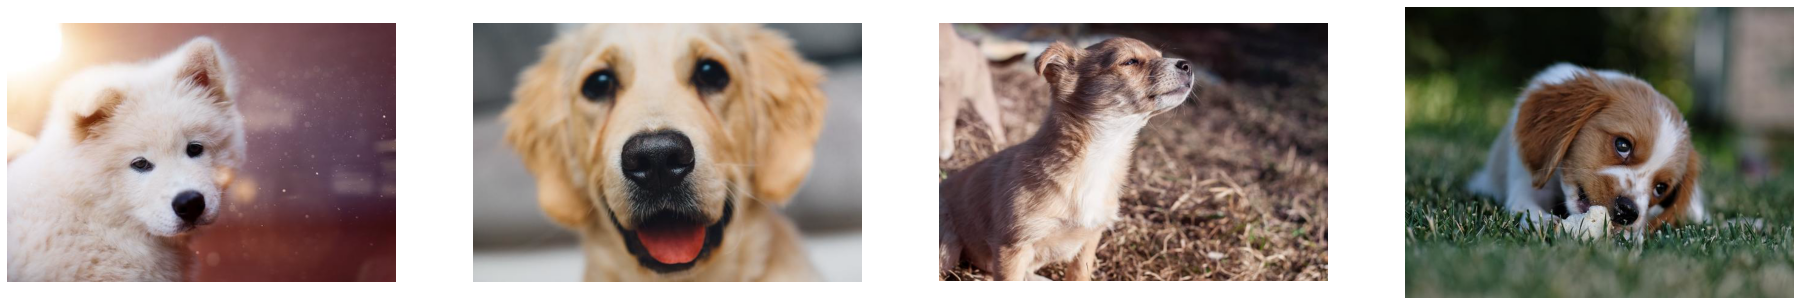

In [4]:
show_images(images.as_cpu())

## Sharding

It is not enough to run pipelines on different GPUs. During the training, each GPU needs to handle different samples at the same time, and this technique is called sharding. To perform sharding the dataset is divided into multiple parts or shards, and each GPU gets its own shard to process.

![sharding.png](../../images/sharding.png)

In DALI sharding is controlled by the following parameters of every reader op:

 - `shard_id`
 
 - `num_shards`. 
 
For more information on these parameters you can look into any reader operator documentation.

In the following sample, you can see how pipeline uses `shard_id` and `num_shards`:

In [5]:
def sharded_pipeline(device_id, shard_id, num_shards):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=device_id)
    with pipe:
        jpegs, labels = fn.readers.file(
            file_root=image_dir,
            random_shuffle=False,
            shard_id=shard_id,
            num_shards=num_shards,
        )
        images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)

        pipe.set_outputs(images, labels)

    return pipe

1. Create and run two pipelines on two different GPUs and take samples from different shards of the dataset.

In [6]:
# Create and build pipelines
pipe_one = sharded_pipeline(device_id=0, shard_id=0, num_shards=2)
pipe_one.build()

pipe_two = sharded_pipeline(device_id=1, shard_id=1, num_shards=2)
pipe_two.build()

# Run pipelines
images_one, labels_one = pipe_one.run()
images_two, labels_two = pipe_two.run()

2. When the images are printed we can clearly see that each pipeline processed different samples.

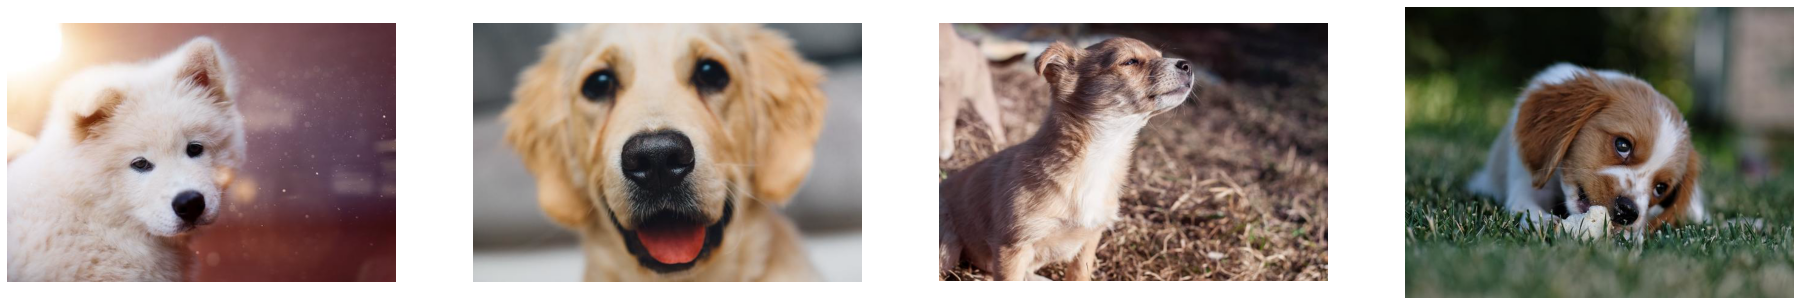

In [7]:
show_images(images_one.as_cpu())

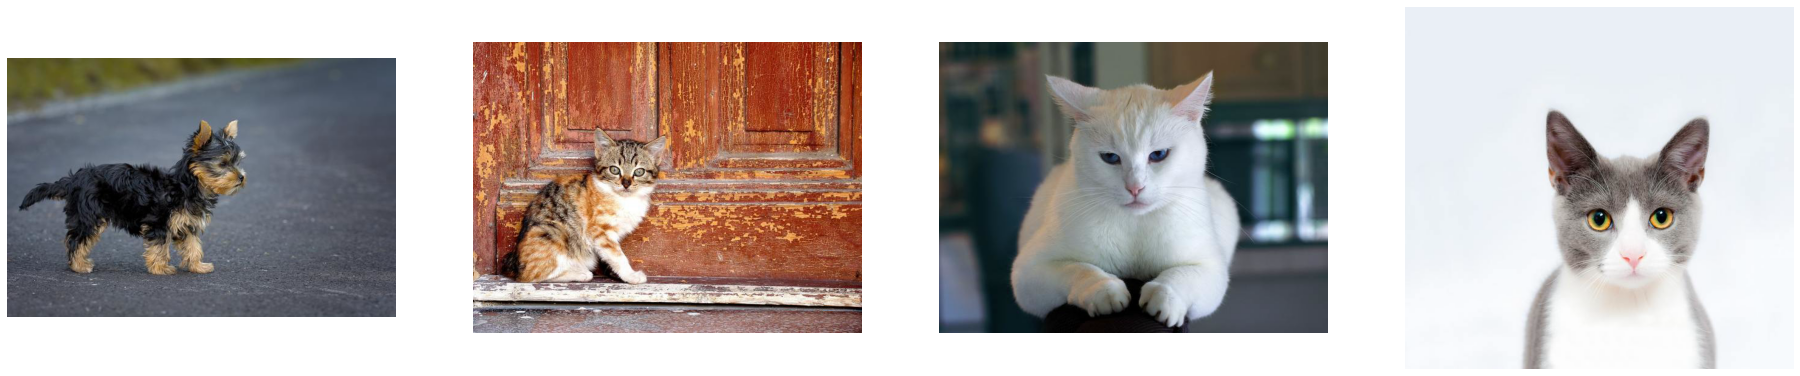

In [8]:
show_images(images_two.as_cpu())

In this simple tutorial we show you how to run DALI pipelines on multiple GPUs by using sharding. For more comprehensive examples in different frameworks please refer to training scripts that are availible for ResNet50 for [PaddlePadle](../use_cases/paddle/resnet50/paddle-resnet50.rst), [PyTorch](../use_cases/pytorch/resnet50/pytorch-resnet50.rst) and [TensorFlow](../use_cases/tensorflow/resnet-n/README.rst). 

**Note**: These scripts work with multiple GPU systems.